# Algorithm Comparison with Hyperparameter Optimization

This notebook compares DTSCAN with DBSCAN, K-means, and Spectral Clustering using hyperparameter optimization for all algorithms.

**Reference**: "Delaunay Triangulation-Based Spatial Clustering Technique for Enhanced Adjacent Boundary Detection and Segmentation of LiDAR 3D Point Clouds" by Kim & Cho (2019)


In [ ]:
import sys
import os
sys.path.insert(0, './code')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import DBSCAN, KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from dtscan import (
    DTSCAN,
    calculate_psr_vsr
)

from cluster_sets import (
    cluster_test_1,
    cluster_test_2,
    cluster_test_3,
    clusters_paper
)


All imports successful!


## 1. Hyperparameter Optimization Functions

Define HPO functions for each algorithm.


In [5]:
def hpo_dtscan(X, true_labels, expected_clusters, verbose=False):
    """Hyperparameter optimization for DTSCAN."""
    z_thresholds = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
    min_pts_values = [3, 4, 5, 6, 7, 8, 10, 12]
    
    results = []
    import io
    from contextlib import redirect_stdout
    
    for z_thresh, min_pts in product(z_thresholds, min_pts_values):
        try:
            start = time.time()
            dtscan = DTSCAN(z_score_threshold=z_thresh, min_pts=min_pts)
            f = io.StringIO()
            with redirect_stdout(f):
                labels = dtscan.fit_predict(X)
            elapsed = time.time() - start
            
            n_clusters = len(np.unique(labels[labels != -1]))
            psr, vsr = calculate_psr_vsr(true_labels, labels)
            cluster_error = abs(n_clusters - expected_clusters)
            cluster_penalty = cluster_error / max(expected_clusters, 1)
            combined_score = 0.4 * psr + 0.4 * vsr + 0.2 * (1 - min(cluster_penalty, 1))
            
            results.append({
                'algorithm': 'DTSCAN',
                'z_threshold': z_thresh,
                'min_pts': min_pts,
                'eps': np.nan,
                'n_clusters': n_clusters,
                'PSR': psr,
                'VSR': vsr,
                'cluster_error': cluster_error,
                'combined_score': combined_score,
                'time': elapsed
            })
        except:
            pass
    
    df = pd.DataFrame(results)
    if len(df) > 0:
        best = df.loc[df['combined_score'].idxmax()]
        return df, {
            'z_threshold': best['z_threshold'],
            'min_pts': int(best['min_pts']),
            'labels': None  # Will be computed later
        }
    return df, None

def hpo_dbscan(X, true_labels, expected_clusters, verbose=False):
    """Hyperparameter optimization for DBSCAN."""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Estimate eps range
    nbrs = NearestNeighbors(n_neighbors=6).fit(X_scaled)
    distances, _ = nbrs.kneighbors(X_scaled)
    distances_sorted = np.sort(distances[:, 5])
    eps_min = np.percentile(distances_sorted, 10)
    eps_max = np.percentile(distances_sorted, 90)
    eps_values = np.linspace(eps_min, eps_max, 10)
    min_samples_values = [3, 4, 5, 6, 7, 8, 10, 12]
    
    results = []
    for eps, min_samples in product(eps_values, min_samples_values):
        try:
            start = time.time()
            dbscan = DBSCAN(eps=eps, min_samples=int(min_samples))
            labels = dbscan.fit_predict(X_scaled)
            elapsed = time.time() - start
            
            n_clusters = len(np.unique(labels[labels != -1]))
            psr, vsr = calculate_psr_vsr(true_labels, labels)
            cluster_error = abs(n_clusters - expected_clusters)
            cluster_penalty = cluster_error / max(expected_clusters, 1)
            combined_score = 0.4 * psr + 0.4 * vsr + 0.2 * (1 - min(cluster_penalty, 1))
            
            results.append({
                'algorithm': 'DBSCAN',
                'z_threshold': np.nan,
                'min_pts': min_samples,
                'eps': eps,
                'n_clusters': n_clusters,
                'PSR': psr,
                'VSR': vsr,
                'cluster_error': cluster_error,
                'combined_score': combined_score,
                'time': elapsed
            })
        except:
            pass
    
    df = pd.DataFrame(results)
    if len(df) > 0:
        best = df.loc[df['combined_score'].idxmax()]
        return df, {
            'eps': best['eps'],
            'min_samples': int(best['min_pts']),
            'labels': None
        }
    return df, None

def hpo_kmeans(X, true_labels, expected_clusters, verbose=False):
    """Hyperparameter optimization for K-means."""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Try different k values around expected
    k_values = list(range(max(2, expected_clusters - 2), expected_clusters + 5))
    n_init_values = [5, 10, 20]
    
    results = []
    for k, n_init in product(k_values, n_init_values):
        try:
            start = time.time()
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=n_init)
            labels = kmeans.fit_predict(X_scaled)
            elapsed = time.time() - start
            
            psr, vsr = calculate_psr_vsr(true_labels, labels)
            cluster_error = abs(k - expected_clusters)
            cluster_penalty = cluster_error / max(expected_clusters, 1)
            combined_score = 0.4 * psr + 0.4 * vsr + 0.2 * (1 - min(cluster_penalty, 1))
            
            results.append({
                'algorithm': 'K-means',
                'z_threshold': np.nan,
                'min_pts': np.nan,
                'eps': np.nan,
                'n_clusters': k,
                'n_init': n_init,
                'PSR': psr,
                'VSR': vsr,
                'cluster_error': cluster_error,
                'combined_score': combined_score,
                'time': elapsed
            })
        except:
            pass
    
    df = pd.DataFrame(results)
    if len(df) > 0:
        best = df.loc[df['combined_score'].idxmax()]
        return df, {
            'n_clusters': int(best['n_clusters']),
            'n_init': int(best['n_init']),
            'labels': None
        }
    return df, None

def hpo_spectral(X, true_labels, expected_clusters, verbose=False):
    """Hyperparameter optimization for Spectral Clustering."""
    if len(X) >= 1000:
        return pd.DataFrame(), None  # Skip for large datasets
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    k_values = list(range(max(2, expected_clusters - 2), expected_clusters + 5))
    n_neighbors_values = [5, 10, 15, 20]
    
    results = []
    for k, n_neighbors in product(k_values, n_neighbors_values):
        try:
            start = time.time()
            spectral = SpectralClustering(
                n_clusters=k,
                affinity='nearest_neighbors',
                n_neighbors=n_neighbors,
                random_state=42
            )
            labels = spectral.fit_predict(X_scaled)
            elapsed = time.time() - start
            
            psr, vsr = calculate_psr_vsr(true_labels, labels)
            cluster_error = abs(k - expected_clusters)
            cluster_penalty = cluster_error / max(expected_clusters, 1)
            combined_score = 0.4 * psr + 0.4 * vsr + 0.2 * (1 - min(cluster_penalty, 1))
            
            results.append({
                'algorithm': 'Spectral',
                'z_threshold': np.nan,
                'min_pts': np.nan,
                'eps': np.nan,
                'n_clusters': k,
                'n_neighbors': n_neighbors,
                'PSR': psr,
                'VSR': vsr,
                'cluster_error': cluster_error,
                'combined_score': combined_score,
                'time': elapsed
            })
        except:
            pass
    
    df = pd.DataFrame(results)
    if len(df) > 0:
        best = df.loc[df['combined_score'].idxmax()]
        return df, {
            'n_clusters': int(best['n_clusters']),
            'n_neighbors': int(best['n_neighbors']),
            'labels': None
        }
    return df, None

print("HPO functions defined!")


HPO functions defined!


## 2. Run HPO on All Algorithms

Perform hyperparameter optimization for all algorithms on all datasets.


In [ ]:
# Generate datasets
datasets = {
    'S1': generate_test_data_s1(),
    'S2': generate_test_data_s2(),
    'S3': generate_test_data_s3()
}

# Run HPO for all algorithms on all datasets
all_hpo_results = {}

for name, (X, true_labels) in datasets.items():
    print(f"\n{'='*80}")
    print(f"Running HPO on {name}")
    print(f"{'='*80}")
    
    expected_clusters = len(np.unique(true_labels[true_labels != -1]))
    all_hpo_results[name] = {}
    
    # DTSCAN
    print(f"\nDTSCAN HPO...")
    df_dt, best_dt = hpo_dtscan(X, true_labels, expected_clusters, verbose=True)
    all_hpo_results[name]['DTSCAN'] = {'df': df_dt, 'best': best_dt}
    if best_dt:
        print(f"  Best: z={best_dt['z_threshold']}, min_pts={best_dt['min_pts']}, "
              f"score={df_dt['combined_score'].max():.3f}")
    
    # DBSCAN
    print(f"\nDBSCAN HPO...")
    df_db, best_db = hpo_dbscan(X, true_labels, expected_clusters, verbose=True)
    all_hpo_results[name]['DBSCAN'] = {'df': df_db, 'best': best_db}
    if best_db:
        print(f"  Best: eps={best_db['eps']:.3f}, min_samples={best_db['min_samples']}, "
              f"score={df_db['combined_score'].max():.3f}")
    
    # K-means
    print(f"\nK-means HPO...")
    df_km, best_km = hpo_kmeans(X, true_labels, expected_clusters, verbose=True)
    all_hpo_results[name]['K-means'] = {'df': df_km, 'best': best_km}
    if best_km:
        print(f"  Best: n_clusters={best_km['n_clusters']}, n_init={best_km['n_init']}, "
              f"score={df_km['combined_score'].max():.3f}")
    
    # Spectral
    if len(X) < 1000:
        print(f"\nSpectral Clustering HPO...")
        df_sp, best_sp = hpo_spectral(X, true_labels, expected_clusters, verbose=True)
        all_hpo_results[name]['Spectral'] = {'df': df_sp, 'best': best_sp}
        if best_sp:
            print(f"  Best: n_clusters={best_sp['n_clusters']}, n_neighbors={best_sp['n_neighbors']}, "
                  f"score={df_sp['combined_score'].max():.3f}")
    else:
        print(f"\nSpectral Clustering skipped (dataset too large)")
        all_hpo_results[name]['Spectral'] = {'df': pd.DataFrame(), 'best': None}

print("\n✓ All HPO complete!")



Running HPO on S1

DTSCAN HPO...
  Best: z=1.0, min_pts=6, score=0.747

DBSCAN HPO...
  Best: eps=0.113, min_samples=7, score=0.752

K-means HPO...
  Best: n_clusters=7, n_init=20, score=0.848

Spectral Clustering HPO...
  Best: n_clusters=7, n_neighbors=15, score=0.883

Running HPO on S2

DTSCAN HPO...
  Best: z=1.0, min_pts=3, score=1.000

DBSCAN HPO...
  Best: eps=0.228, min_samples=3, score=0.924

K-means HPO...
  Best: n_clusters=3, n_init=5, score=0.744

Spectral Clustering HPO...
  Best: n_clusters=3, n_neighbors=15, score=1.000

Running HPO on S3

DTSCAN HPO...
  Best: z=0.5, min_pts=4, score=0.927

DBSCAN HPO...
  Best: eps=0.224, min_samples=4, score=0.776

K-means HPO...
  Best: n_clusters=2, n_init=5, score=0.949

Spectral Clustering HPO...
  Best: n_clusters=2, n_neighbors=10, score=0.965

✓ All HPO complete!


## 3. Generate Best Results with Optimized Parameters

Run each algorithm with its best parameters and store results for visualization.


In [7]:
# Generate best results for visualization
best_results = {}

for name, (X, true_labels) in datasets.items():
    best_results[name] = {'X': X, 'true_labels': true_labels}
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # DTSCAN
    if all_hpo_results[name]['DTSCAN']['best']:
        best_dt = all_hpo_results[name]['DTSCAN']['best']
        dtscan = DTSCAN(z_score_threshold=best_dt['z_threshold'], min_pts=best_dt['min_pts'])
        import io
        from contextlib import redirect_stdout
        f = io.StringIO()
        with redirect_stdout(f):
            labels_dt = dtscan.fit_predict(X)
        psr_dt, vsr_dt = calculate_psr_vsr(true_labels, labels_dt)
        best_results[name]['DTSCAN'] = {
            'labels': labels_dt,
            'PSR': psr_dt,
            'VSR': vsr_dt,
            'clusters': len(np.unique(labels_dt[labels_dt != -1])),
            'params': best_dt
        }
    
    # DBSCAN
    if all_hpo_results[name]['DBSCAN']['best']:
        best_db = all_hpo_results[name]['DBSCAN']['best']
        dbscan = DBSCAN(eps=best_db['eps'], min_samples=best_db['min_samples'])
        labels_db = dbscan.fit_predict(X_scaled)
        psr_db, vsr_db = calculate_psr_vsr(true_labels, labels_db)
        best_results[name]['DBSCAN'] = {
            'labels': labels_db,
            'PSR': psr_db,
            'VSR': vsr_db,
            'clusters': len(np.unique(labels_db[labels_db != -1])),
            'params': best_db
        }
    
    # K-means
    if all_hpo_results[name]['K-means']['best']:
        best_km = all_hpo_results[name]['K-means']['best']
        kmeans = KMeans(n_clusters=best_km['n_clusters'], n_init=best_km['n_init'], random_state=42)
        labels_km = kmeans.fit_predict(X_scaled)
        psr_km, vsr_km = calculate_psr_vsr(true_labels, labels_km)
        best_results[name]['K-means'] = {
            'labels': labels_km,
            'PSR': psr_km,
            'VSR': vsr_km,
            'clusters': len(np.unique(labels_km)),
            'params': best_km
        }
    
    # Spectral
    if all_hpo_results[name]['Spectral']['best']:
        best_sp = all_hpo_results[name]['Spectral']['best']
        spectral = SpectralClustering(
            n_clusters=best_sp['n_clusters'],
            n_neighbors=best_sp['n_neighbors'],
            affinity='nearest_neighbors',
            random_state=42
        )
        labels_sp = spectral.fit_predict(X_scaled)
        psr_sp, vsr_sp = calculate_psr_vsr(true_labels, labels_sp)
        best_results[name]['Spectral'] = {
            'labels': labels_sp,
            'PSR': psr_sp,
            'VSR': vsr_sp,
            'clusters': len(np.unique(labels_sp)),
            'params': best_sp
        }

print("✓ Best results generated!")


✓ Best results generated!


## 4. Display HPO Results as DataFrames


In [8]:
# Display HPO results summary
for name in ['S1', 'S2', 'S3']:
    print(f"\n{'='*80}")
    print(f"HPO Results Summary - {name}")
    print(f"{'='*80}")
    
    summary_data = []
    for algo in ['DTSCAN', 'DBSCAN', 'K-means', 'Spectral']:
        if algo in all_hpo_results[name] and len(all_hpo_results[name][algo]['df']) > 0:
            df = all_hpo_results[name][algo]['df']
            best_row = df.loc[df['combined_score'].idxmax()]
            summary_data.append({
                'Algorithm': algo,
                'Best Score': best_row['combined_score'],
                'PSR': best_row['PSR'],
                'VSR': best_row['VSR'],
                'Clusters': int(best_row['n_clusters']),
                'Expected': len(np.unique(datasets[name][1][datasets[name][1] != -1])),
                'Time (s)': best_row['time']
            })
    
    summary_df = pd.DataFrame(summary_data)
    display(summary_df.style.format({
        'Best Score': '{:.3f}',
        'PSR': '{:.3f}',
        'VSR': '{:.3f}',
        'Time (s)': '{:.4f}'
    }).background_gradient(subset=['Best Score', 'PSR', 'VSR'], cmap='YlGnBu'))
    
    # Display top 5 for each algorithm
    print(f"\nTop 5 Parameter Combinations per Algorithm:")
    for algo in ['DTSCAN', 'DBSCAN', 'K-means', 'Spectral']:
        if algo in all_hpo_results[name] and len(all_hpo_results[name][algo]['df']) > 0:
            df = all_hpo_results[name][algo]['df']
            top5 = df.nlargest(5, 'combined_score')
            print(f"\n{algo}:")
            display_cols = ['PSR', 'VSR', 'n_clusters', 'combined_score']
            if 'z_threshold' in top5.columns:
                display_cols = ['z_threshold', 'min_pts'] + display_cols
            elif 'eps' in top5.columns:
                display_cols = ['eps', 'min_pts'] + display_cols
            elif 'n_clusters' in top5.columns and 'n_init' in top5.columns:
                display_cols = ['n_clusters', 'n_init'] + display_cols
            
            display(top5[display_cols].style.format({
                'PSR': '{:.3f}',
                'VSR': '{:.3f}',
                'combined_score': '{:.3f}',
                'z_threshold': '{:.1f}',
                'eps': '{:.3f}'
            }).background_gradient(subset=['combined_score'], cmap='YlGnBu'))



HPO Results Summary - S1


,Algorithm,Best Score,PSR,VSR,Clusters,Expected,Time (s)
0,DTSCAN,0.747,0.661,0.707,7,7,0.0131
1,DBSCAN,0.752,0.703,0.678,7,7,0.0023
2,K-means,0.848,0.816,0.805,7,7,0.0274
3,Spectral,0.883,0.863,0.845,7,7,0.0390



Top 5 Parameter Combinations per Algorithm:

DTSCAN:


,z_threshold,min_pts,PSR,VSR,n_clusters,combined_score
11,1.0,6,0.661,0.707,7,0.747
1,0.5,4,0.572,0.625,5,0.622
2,0.5,5,0.570,0.623,5,0.620
3,0.5,6,0.702,0.701,12,0.619
62,4.0,10,0.087,0.932,7,0.607



DBSCAN:


,z_threshold,min_pts,PSR,VSR,n_clusters,combined_score
52,nan,7,0.703,0.678,7,0.752
53,nan,8,0.668,0.679,7,0.739
75,nan,6,0.656,0.683,7,0.736
63,nan,12,0.651,0.640,7,0.716
77,nan,8,0.620,0.672,7,0.716



K-means:


,z_threshold,min_pts,PSR,VSR,n_clusters,combined_score
8,nan,nan,0.816,0.805,7,0.848
6,nan,nan,0.813,0.800,7,0.845
7,nan,nan,0.813,0.800,7,0.845
10,nan,nan,0.817,0.799,8,0.818
11,nan,nan,0.817,0.799,8,0.818



Spectral:


,z_threshold,min_pts,PSR,VSR,n_clusters,combined_score
10,nan,nan,0.863,0.845,7,0.883
11,nan,nan,0.857,0.838,7,0.878
9,nan,nan,0.835,0.826,7,0.864
8,nan,nan,0.829,0.824,7,0.861
14,nan,nan,0.832,0.799,8,0.824



HPO Results Summary - S2


,Algorithm,Best Score,PSR,VSR,Clusters,Expected,Time (s)
0,DTSCAN,1.000,1.000,1.000,3,3,0.0113
1,DBSCAN,0.924,0.988,0.989,4,3,0.0015
2,K-means,0.744,0.492,0.867,3,3,0.0087
3,Spectral,1.000,1.000,1.000,3,3,0.0424



Top 5 Parameter Combinations per Algorithm:

DTSCAN:


,z_threshold,min_pts,PSR,VSR,n_clusters,combined_score
8,1.0,3,1.000,1.000,3,1.000
9,1.0,4,1.000,1.000,3,1.000
16,1.5,3,1.000,1.000,3,1.000
17,1.5,4,1.000,1.000,3,1.000
18,1.5,5,1.000,1.000,3,1.000



DBSCAN:


,z_threshold,min_pts,PSR,VSR,n_clusters,combined_score
72,nan,3,0.988,0.989,4,0.924
73,nan,4,0.988,0.989,4,0.924
74,nan,5,0.862,0.815,5,0.737
75,nan,6,0.856,0.807,5,0.732
46,nan,10,0.651,0.562,3,0.685



K-means:


,z_threshold,min_pts,PSR,VSR,n_clusters,combined_score
3,nan,nan,0.492,0.867,3,0.744
4,nan,nan,0.492,0.867,3,0.744
5,nan,nan,0.492,0.867,3,0.744
0,nan,nan,0.438,0.914,2,0.674
1,nan,nan,0.438,0.914,2,0.674



Spectral:


,z_threshold,min_pts,PSR,VSR,n_clusters,combined_score
6,nan,nan,1.000,1.000,3,1.000
7,nan,nan,1.000,1.000,3,1.000
9,nan,nan,0.840,0.774,4,0.779
10,nan,nan,0.840,0.774,4,0.779
5,nan,nan,0.677,0.769,3,0.779



HPO Results Summary - S3


,Algorithm,Best Score,PSR,VSR,Clusters,Expected,Time (s)
0,DTSCAN,0.927,0.822,0.995,2,2,0.0155
1,DBSCAN,0.776,0.539,0.902,2,2,0.0015
2,K-means,0.949,0.877,0.996,2,2,0.0112
3,Spectral,0.965,0.914,0.999,2,2,0.0401



Top 5 Parameter Combinations per Algorithm:

DTSCAN:


,z_threshold,min_pts,PSR,VSR,n_clusters,combined_score
1,0.5,4,0.822,0.995,2,0.927
10,1.0,5,0.497,0.981,2,0.791
11,1.0,6,0.495,0.981,2,0.791
18,1.5,5,0.500,0.984,1,0.693
16,1.5,3,0.500,0.983,1,0.693



DBSCAN:


,z_threshold,min_pts,PSR,VSR,n_clusters,combined_score
73,nan,4,0.539,0.902,2,0.776
74,nan,5,0.540,0.900,2,0.776
64,nan,3,0.492,0.986,3,0.691
72,nan,3,0.497,0.980,1,0.691
65,nan,4,0.528,0.907,3,0.674



K-means:


,z_threshold,min_pts,PSR,VSR,n_clusters,combined_score
0,nan,nan,0.877,0.996,2,0.949
1,nan,nan,0.877,0.996,2,0.949
2,nan,nan,0.877,0.996,2,0.949
3,nan,nan,0.629,0.842,3,0.688
4,nan,nan,0.629,0.842,3,0.688



Spectral:


,z_threshold,min_pts,PSR,VSR,n_clusters,combined_score
1,nan,nan,0.914,0.999,2,0.965
2,nan,nan,0.898,0.998,2,0.959
3,nan,nan,0.892,0.998,2,0.956
0,nan,nan,0.812,0.994,2,0.922
5,nan,nan,0.596,0.923,3,0.707


## 5. Visualize Comparison Results

Create side-by-side visualizations comparing all algorithms.


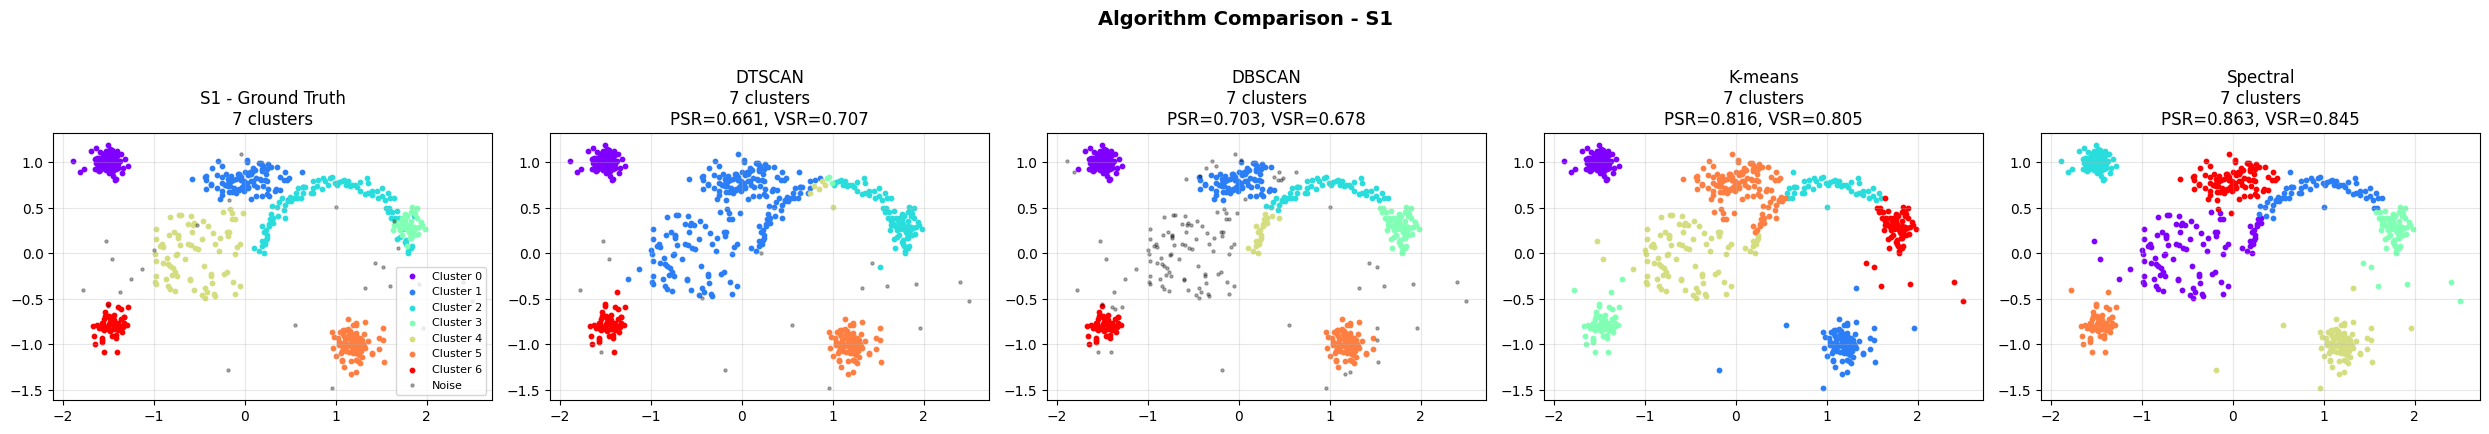

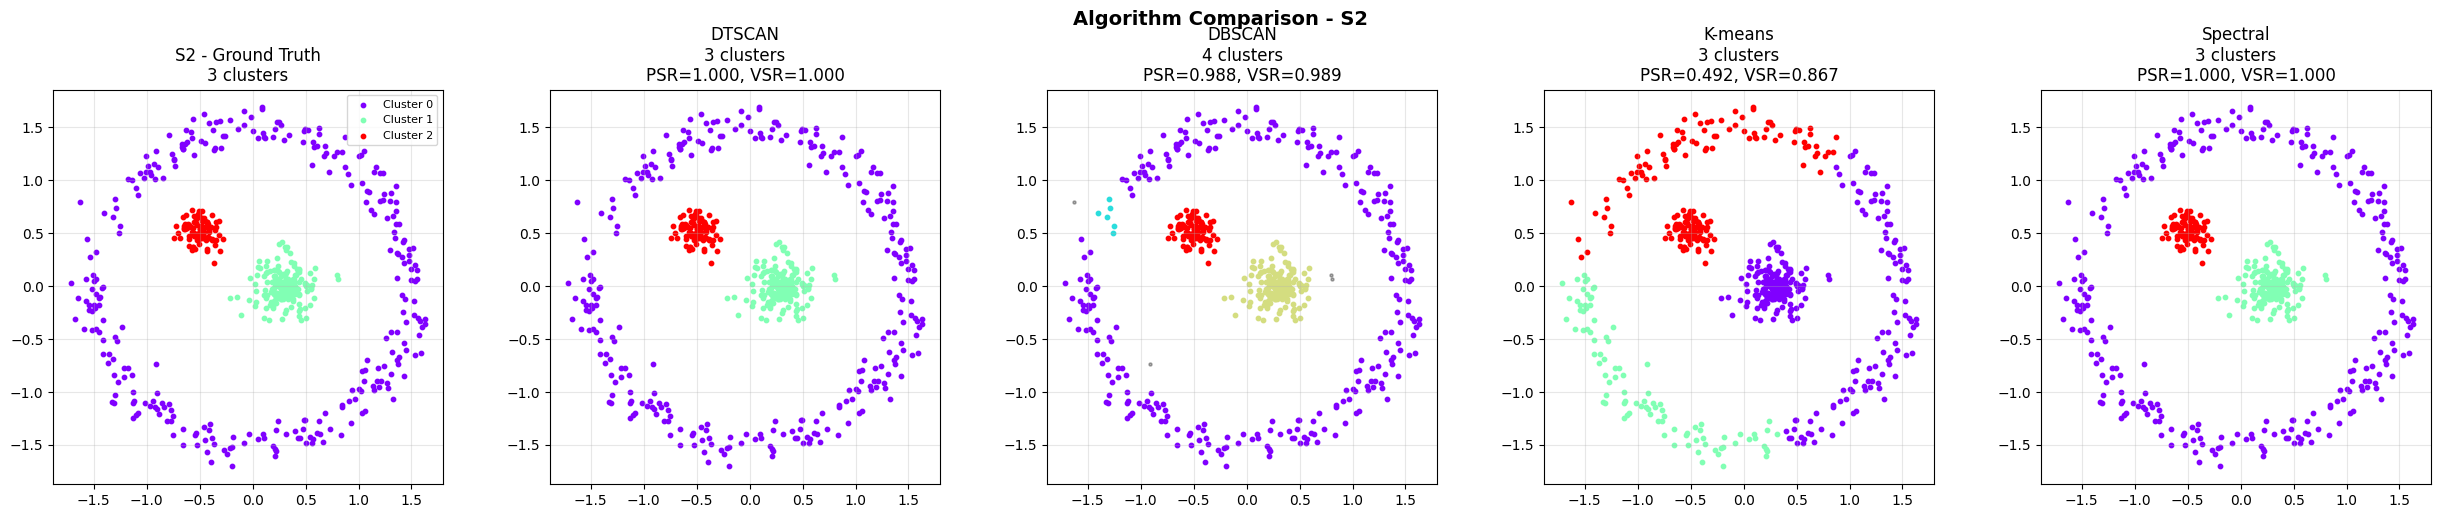

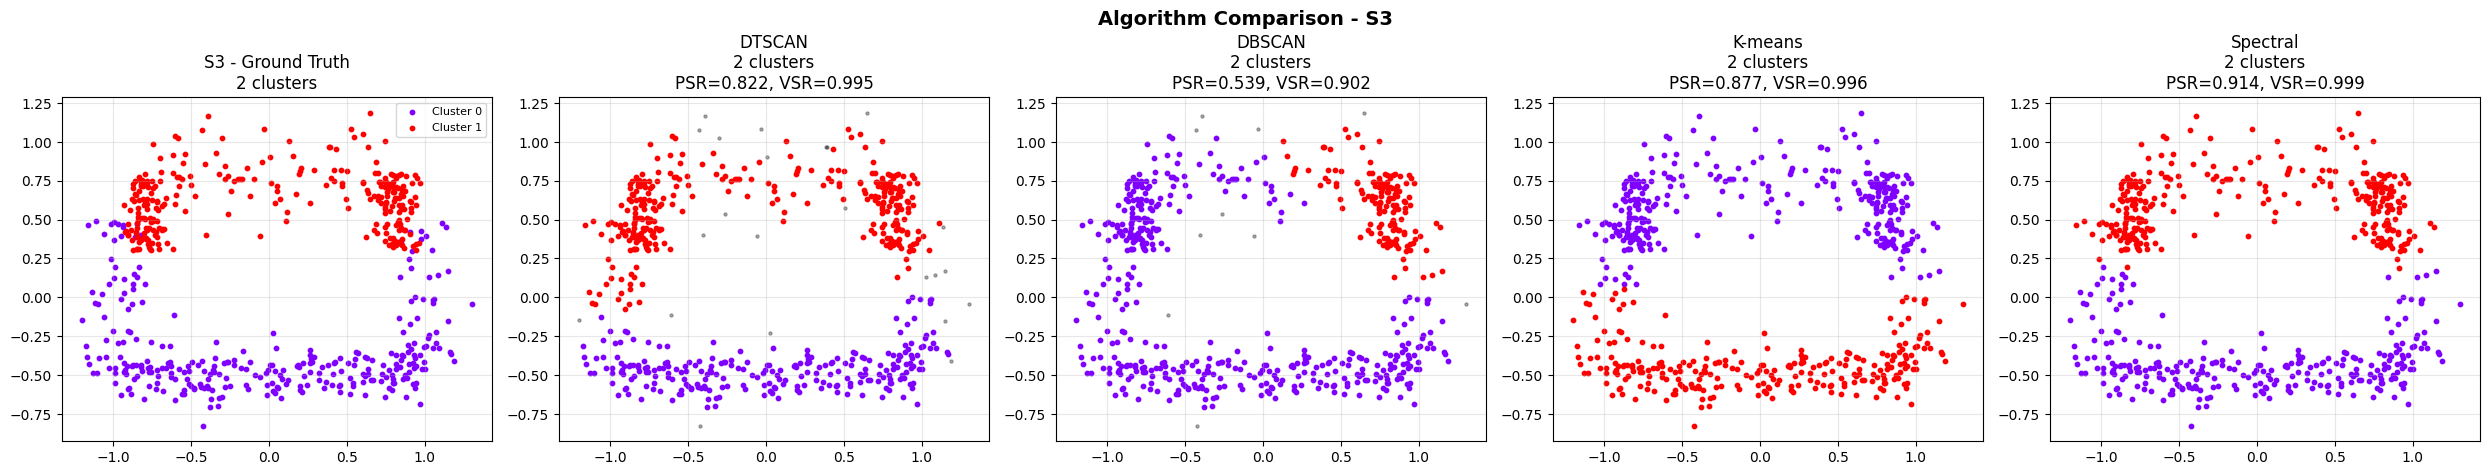

In [9]:
# Visualize results for each dataset
for name in ['S1', 'S2', 'S3']:
    X = best_results[name]['X']
    true_labels = best_results[name]['true_labels']
    expected_clusters = len(np.unique(true_labels[true_labels != -1]))
    
    # Determine number of algorithms
    algorithms = [algo for algo in ['DTSCAN', 'DBSCAN', 'K-means', 'Spectral'] 
                  if algo in best_results[name]]
    n_algorithms = len(algorithms) + 1  # +1 for ground truth
    
    fig, axes = plt.subplots(1, n_algorithms, figsize=(5*n_algorithms, 5))
    if n_algorithms == 1:
        axes = [axes]
    
    # Plot ground truth
    ax = axes[0]
    unique_true = np.unique(true_labels[true_labels != -1])
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_true)))
    for i, label in enumerate(unique_true):
        mask = true_labels == label
        ax.scatter(X[mask, 0], X[mask, 1], c=[colors[i]], s=10, label=f'Cluster {int(label)}')
    noise_mask = true_labels == -1
    if np.any(noise_mask):
        ax.scatter(X[noise_mask, 0], X[noise_mask, 1], c='black', s=5, alpha=0.3, label='Noise')
    ax.set_title(f'{name} - Ground Truth\n{expected_clusters} clusters')
    ax.set_aspect('equal')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Plot each algorithm
    for idx, algo in enumerate(algorithms, 1):
        ax = axes[idx]
        algo_data = best_results[name][algo]
        labels = algo_data['labels']
        unique_pred = np.unique(labels[labels != -1])
        
        if len(unique_pred) > 0:
            colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_pred)))
            for i, label in enumerate(unique_pred):
                mask = labels == label
                ax.scatter(X[mask, 0], X[mask, 1], c=[colors[i]], s=10)
        
        noise_mask = labels == -1
        if np.any(noise_mask):
            ax.scatter(X[noise_mask, 0], X[noise_mask, 1], c='black', s=5, alpha=0.3)
        
        ax.set_title(f'{algo}\n{algo_data["clusters"]} clusters\n'
                     f'PSR={algo_data["PSR"]:.3f}, VSR={algo_data["VSR"]:.3f}')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Algorithm Comparison - {name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


## 6. Performance Comparison Table

Create a comprehensive comparison table.


In [10]:
# Create comprehensive comparison table
comparison_data = []

for name in ['S1', 'S2', 'S3']:
    expected = len(np.unique(datasets[name][1][datasets[name][1] != -1]))
    for algo in ['DTSCAN', 'DBSCAN', 'K-means', 'Spectral']:
        if algo in best_results[name]:
            algo_data = best_results[name][algo]
            comparison_data.append({
                'Dataset': name,
                'Algorithm': algo,
                'Expected Clusters': expected,
                'Found Clusters': algo_data['clusters'],
                'Cluster Match': '✓' if algo_data['clusters'] == expected else '✗',
                'PSR': algo_data['PSR'],
                'VSR': algo_data['VSR'],
                'Combined Score': 0.4 * algo_data['PSR'] + 0.4 * algo_data['VSR'] + 
                                0.2 * (1 if algo_data['clusters'] == expected else 0)
            })

comparison_table = pd.DataFrame(comparison_data)

print("="*80)
print("COMPREHENSIVE ALGORITHM COMPARISON")
print("="*80)
display(comparison_table.pivot_table(
    index='Dataset',
    columns='Algorithm',
    values=['Found Clusters', 'PSR', 'VSR', 'Combined Score'],
    aggfunc='first'
).round(3).style.background_gradient(subset=[('PSR', 'DTSCAN'), ('PSR', 'DBSCAN'), 
                                              ('PSR', 'K-means'), ('PSR', 'Spectral'),
                                              ('VSR', 'DTSCAN'), ('VSR', 'DBSCAN'),
                                              ('VSR', 'K-means'), ('VSR', 'Spectral')],
                                     cmap='YlGnBu'))

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
summary_stats = comparison_table.groupby('Algorithm').agg({
    'PSR': ['mean', 'std'],
    'VSR': ['mean', 'std'],
    'Cluster Match': lambda x: sum(x == '✓') / len(x)
}).round(3)
summary_stats.columns = ['PSR Mean', 'PSR Std', 'VSR Mean', 'VSR Std', 'Match Rate']
display(summary_stats.style.background_gradient(subset=['PSR Mean', 'VSR Mean', 'Match Rate'], 
                                                 cmap='YlGnBu'))


COMPREHENSIVE ALGORITHM COMPARISON



SUMMARY STATISTICS


,PSR Mean,PSR Std,VSR Mean,VSR Std,Match Rate
Algorithm,,,,,
DBSCAN,0.743000,0.227000,0.856000,0.160000,0.667000
DTSCAN,0.828000,0.169000,0.901000,0.168000,1.000000
K-means,0.728000,0.207000,0.890000,0.098000,1.000000
Spectral,0.926000,0.069000,0.948000,0.090000,1.000000
